In [2]:
import numpy as np


import matplotlib.pyplot as plt
import random

## The data

The data is from electron microscopy - images of grpahene sheets. The typical image is $(256, 256)$ but we would like to take small patches of this and identify - is there a defect in the patch.

Lets go through a few of those things. Below we will look at 

* A full image
* A patch of an image with no defects
* A patch with a defect

### Full image

In [3]:
graphene = np.load('full-stack.npy') ## This has 180 different microgrpahs each (256, 256)
sample = np.squeeze(graphene[54])

In [4]:
print(sample.shape)

(256, 256)


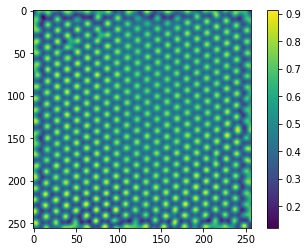

In [5]:
plt.imshow(sample)
plt.colorbar();

#### Description
The blue (high electron density) correspnds to atoms and the green correspnds to background.

You can see that in the middle of the sheet most of it is a pretty regular array of hexagons, this is what we exepct for the perfect lattice. You will also hopefully see some spots where the hexagon is broken. This many of these are the result of missing atom defects. 

Notice the edges look a bit weird too. This is standard, and we will generally ignore the edges when analysing.



### Perfect patch

There is a training dataset of perfect patches 

In [48]:
pp = np.load('./perfect_patches.npy')
perfect_sample = pp[0] 
print(pp.shape)

(2279, 48, 48)


(0.12360269, 0.0072767125, 24.593985, 24.593985, 3.0398827, 0.17896335)

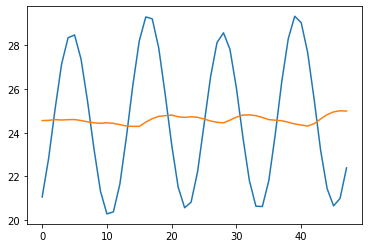

In [71]:
n1 = np.sum(perfect_sample, axis=0)
plt.plot(n1)
e1 = np.std(n1)/np.mean(n1)
n2 = np.sum(perfect_sample, axis=1)
e2 = np.std(n2)/np.mean(n2)
plt.plot(n2)
e1, e2, np.mean(n1), np.mean(n2), np.std(n1), np.std(n2)


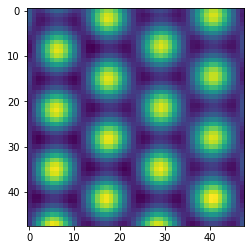

In [8]:
plt.imshow(perfect_sample);

### Defect patch

There is also a set of defective patches. Note - these are for testing only, not for training. I guess we could imagine training a classifier on these and the perfect patches - but that would be no fun :)

In [51]:
dp = np.load('./defect_patches.npy')
defect_sample = dp[0] 
print(dp.shape)


(32, 48, 48)


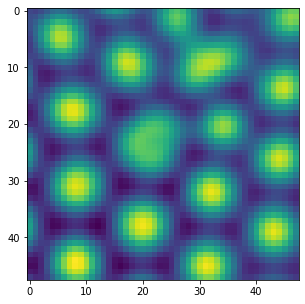

In [52]:
plt.figure(figsize=(5, 5))
plt.imshow(defect_sample);

(0.1249781, 0.03558564, 25.00563, 25.005632, 3.1251562, 0.8898415)

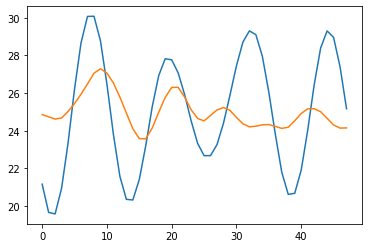

In [70]:
n1 = np.sum(defect_sample, axis=0)
plt.plot(n1)
e1 = np.std(n1)/np.mean(n1)
n2 = np.sum(defect_sample, axis=1)
e2 = np.std(n2)/np.mean(n2)
plt.plot(n2)
e1, e2, np.mean(n1), np.mean(n2), np.std(n1), np.std(n2)


Get patches perfect and defect, and put them randomly in a list, with the ground truth saved

In [11]:
patches = np.concatenate([pp, dp])
gt = np.concatenate([np.zeros(len(pp)), np.ones(len(dp))])
xy = list(zip(patches, gt)) # put labels with data in (data, label) tuple
random.shuffle(xy) # shuffle the tuples

In [12]:
patches, gt = list(zip(*xy)) # unzip the tuples to get patches and ground truths as vectors

In [13]:
len(patches)

2311

Have fun :-)

In [76]:
def data(image):
    image0 = np.sum(image,axis=0)
    image1 = np.sum(image,axis=1)
    stdim0 = np.std(image0)
    stdim1 = np.std(image1)
    return [stdim0,stdim1]


In [77]:
ppL = []
dpL = []
for i in pp:
    ppL.append(data(i))
for i in dp:
    dpL.append(data(i))


In [81]:
dpL

[[3.1251562, 0.8898415],
 [3.0892646, 0.88678247],
 [3.0357022, 0.882696],
 [3.209078, 0.8972902],
 [3.179671, 0.89595824],
 [3.1332772, 0.8912552],
 [3.2733002, 0.90349567],
 [3.2515552, 0.90517336],
 [3.2126915, 0.90136915],
 [2.80752, 1.0027353],
 [2.7853987, 0.99710906],
 [2.769802, 0.9881873],
 [2.7678292, 0.98319185],
 [2.7764282, 0.9833975],
 [2.7902994, 0.9836332],
 [2.8088577, 0.975308],
 [2.837985, 0.95301306],
 [2.8862062, 0.9209992],
 [2.9516876, 0.8927468],
 [3.0173829, 0.881559],
 [3.0631087, 0.88343346],
 [3.0725567, 0.88648653],
 [3.0427337, 0.8833518],
 [2.9850883, 0.87886554],
 [2.9185226, 0.8795515],
 [2.85792, 0.88218695],
 [2.8084033, 0.88020265],
 [2.766312, 0.8747759],
 [2.7292495, 0.8728131],
 [2.7003815, 0.8778877],
 [2.6882079, 0.88732255],
 [2.6955721, 0.89668983]]

In [82]:
ppL

[[3.0398827, 0.17896335],
 [2.9958975, 0.19585349],
 [2.996396, 0.20805487],
 [3.0337048, 0.21238539],
 [3.063423, 0.20751178],
 [3.0513258, 0.19245374],
 [3.0111334, 0.16769016],
 [2.9887345, 0.13898817],
 [3.00931, 0.11802189],
 [3.0480902, 0.1217932],
 [3.056871, 0.15610881],
 [3.0151303, 0.20626462],
 [2.952628, 0.25625625],
 [2.9270966, 0.29671103],
 [2.9639611, 0.32721168],
 [3.0255759, 0.34756467],
 [3.051724, 0.35413337],
 [3.0176191, 0.3461962],
 [2.9568796, 0.3246166],
 [2.928102, 0.29550472],
 [2.9542127, 0.2659188],
 [2.999656, 0.24083143],
 [3.0118985, 0.22533214],
 [2.9748092, 0.21983719],
 [2.9223535, 0.21957299],
 [2.90661, 0.21734475],
 [2.9401212, 0.21174058],
 [2.9829485, 0.2058497],
 [2.9894297, 0.20135],
 [2.9576626, 0.20295814],
 [2.9274216, 0.21309067],
 [2.9362361, 0.2289595],
 [2.9773846, 0.24725695],
 [3.00558, 0.26367247],
 [2.9899905, 0.2746133],
 [2.9435825, 0.27964392],
 [2.9116385, 0.27759296],
 [2.9261594, 0.26867157],
 [2.9675155, 0.25739112],
 [2.98773